In [1]:
# Core
import os, re, string, math, warnings, sys, random
warnings.filterwarnings("ignore")

# Data & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Saving model
import joblib

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Python:", sys.version.split()[0])
import sklearn, matplotlib
print("sklearn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)


Python: 3.11.2
sklearn: 1.7.0
pandas: 2.3.1
matplotlib: 3.10.3


In [2]:

FAKE_PATH = r"C:\Users\aadil\Downloads\Fake.csv"
TRUE_PATH = r"C:\Users\aadil\Downloads\True.csv"

# Load
fake = pd.read_csv(FAKE_PATH)
true = pd.read_csv(TRUE_PATH)

# Label: 0 = fake, 1 = real
fake["class"] = 0
true["class"] = 1

# Keep only columns we’ll use; tolerate missing columns
for df in (fake, true):
    for col in ("text", "title", "subject", "date"):
        if col not in df.columns:
            df[col] = np.nan

# Set aside a small manual test set (5+5) for the UI at the end
fake_mt = fake.sample(n=min(5, len(fake)), random_state=RANDOM_STATE)
true_mt = true.sample(n=min(5, len(true)), random_state=RANDOM_STATE)
manual_test = pd.concat([fake_mt, true_mt], ignore_index=True)

fake = fake.drop(index=fake_mt.index)
true = true.drop(index=true_mt.index)

# Merge
data = pd.concat([fake, true], ignore_index=True)

print(fake.shape, true.shape, data.shape)
data.head()


(23476, 5) (21412, 5) (44888, 5)


,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
# Keep only text + label
if "text" not in data.columns or "class" not in data.columns:
    raise ValueError("Input files must contain at least 'text' and 'class' columns.")

data = data[["text", "class"]].copy()

# Drop obvious empties, force to string
data["text"] = data["text"].fillna("").astype(str)

# Remove duplicates (optional)
before = len(data)
data = data.drop_duplicates(subset=["text", "class"]).reset_index(drop=True)
print(f"Dropped {before - len(data)} duplicate rows.")
print(data["class"].value_counts())


Dropped 6249 duplicate rows.
class
1    21187
0    17452
Name: count, dtype: int64


In [4]:
# Simple, robust cleaner
_punct_table = str.maketrans("", "", string.punctuation)

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\[.*?\]", " ", s)                     # bracketed
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)       # urls
    s = re.sub(r"<.*?>", " ", s)                       # html
    s = s.translate(_punct_table)                      # punctuation
    s = re.sub(r"\d+", " ", s)                         # numbers
    s = re.sub(r"\s+", " ", s).strip()                 # whitespace
    return s

data["text"] = data["text"].map(clean_text)

# Also clean manual set
manual_test["text"] = manual_test["text"].fillna("").astype(str).map(clean_text)

data.head()


,text,class
0,donald trump just couldn t wish all americans ...,0
1,house intelligence committee chairman devin nu...,0
2,on friday it was revealed that former milwauke...,0
3,on christmas day donald trump announced that h...,0
4,pope francis used his annual christmas day mes...,0


In [5]:
X = data["text"].values
y = data["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

len(X_train), len(X_test)


(28979, 9660)

In [6]:
# Cell 2 – Define Vectorizer, Pipelines, and Models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

# One vectorizer used in all models (fits inside each Pipeline)
def make_vectorizer():
    return TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=2,
        stop_words="english",  # avoids NLTK dependency
        sublinear_tf=True
    )

# Pipelines
pipe_lr = Pipeline([
    ("tfidf", make_vectorizer()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))
])

# LinearSVC needs calibration to get predict_proba
base_svc = Pipeline([
    ("tfidf", make_vectorizer()),
    ("clf", LinearSVC(class_weight="balanced"))
])
pipe_svc = Pipeline([
    ("cal", CalibratedClassifierCV(estimator=base_svc, cv=3, method="sigmoid"))
])

pipe_nb = Pipeline([
    ("tfidf", make_vectorizer()),
    ("clf", MultinomialNB(alpha=0.1))
])

# Voting Classifier (soft voting, weighted)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("lr", pipe_lr),
        ("svc", pipe_svc),
        ("nb", pipe_nb)
    ],
    voting="soft",
    weights=[1, 1, 3]   # Naive Bayes given more influence
)

models = {
    "LogisticRegression": pipe_lr,
    "LinearSVC_calibrated": pipe_svc,
    "MultinomialNB": pipe_nb,
    "VotingClassifier": voting_clf
}

list(models.keys())


['LogisticRegression',
 'LinearSVC_calibrated',
 'MultinomialNB',
 'VotingClassifier']


=== LogisticRegression ===
              precision    recall  f1-score   support

     Fake(0)       0.99      0.98      0.99      4363
     Real(1)       0.99      0.99      0.99      5297

    accuracy                           0.99      9660
   macro avg       0.99      0.99      0.99      9660
weighted avg       0.99      0.99      0.99      9660



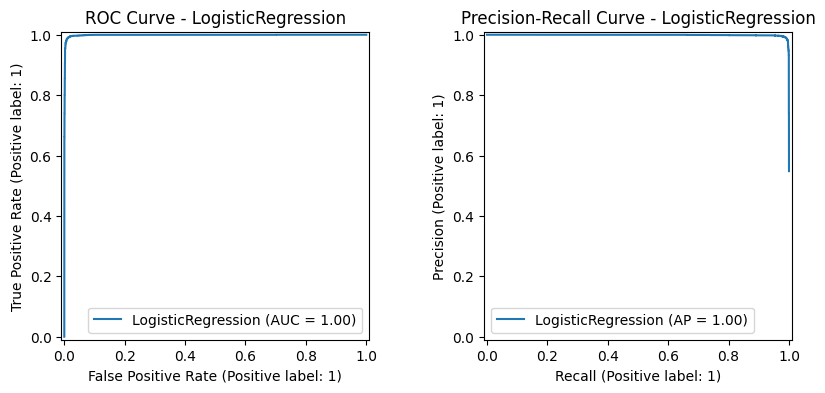


=== LinearSVC_calibrated ===
              precision    recall  f1-score   support

     Fake(0)       1.00      0.99      0.99      4363
     Real(1)       0.99      1.00      0.99      5297

    accuracy                           0.99      9660
   macro avg       0.99      0.99      0.99      9660
weighted avg       0.99      0.99      0.99      9660



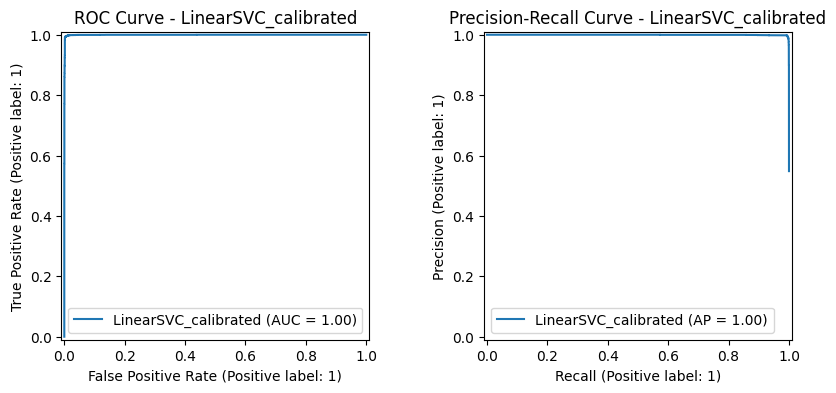


=== MultinomialNB ===
              precision    recall  f1-score   support

     Fake(0)       0.96      0.95      0.95      4363
     Real(1)       0.96      0.96      0.96      5297

    accuracy                           0.96      9660
   macro avg       0.96      0.95      0.95      9660
weighted avg       0.96      0.96      0.96      9660



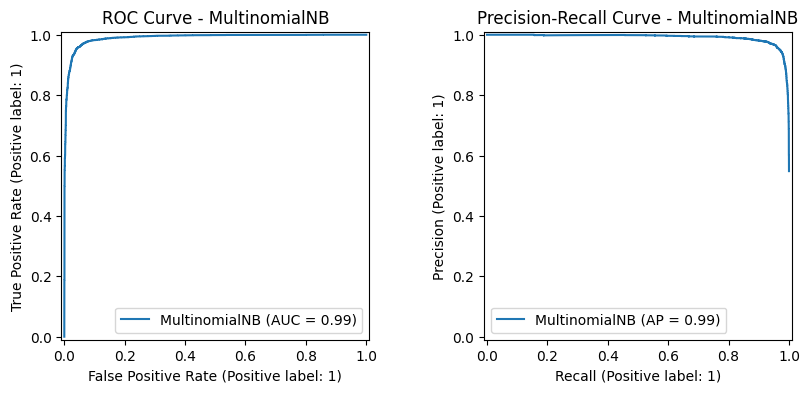


=== VotingClassifier ===
              precision    recall  f1-score   support

     Fake(0)       0.97      0.96      0.97      4363
     Real(1)       0.97      0.98      0.97      5297

    accuracy                           0.97      9660
   macro avg       0.97      0.97      0.97      9660
weighted avg       0.97      0.97      0.97      9660



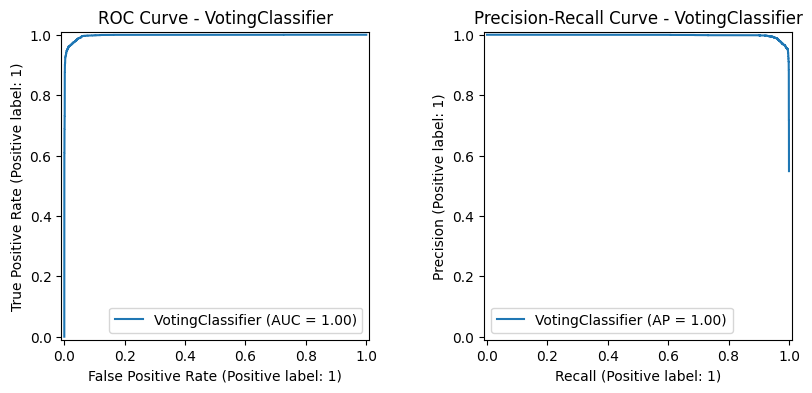

,model,accuracy,precision,recall,f1,roc_auc
0,LinearSVC_calibrated,0.994099,0.993223,0.996035,0.994627,0.999513
1,LogisticRegression,0.988302,0.985212,0.993581,0.989379,0.998843
2,VotingClassifier,0.972050,0.970605,0.978667,0.974619,0.997411
3,MultinomialNB,0.955383,0.955447,0.963564,0.959489,0.989859


In [7]:
# Cell 3 – Train, Evaluate, and Compare Models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

def evaluate_and_plot(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # Probability scores (needed for ROC/PR)
    try:
        y_score = model.predict_proba(X_te)[:, 1]
    except:
        try:
            y_score = model.decision_function(X_te)
        except:
            y_score = None

    # Metrics
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0)
    }
    if y_score is not None:
        metrics["roc_auc"] = roc_auc_score(y_te, y_score)
    else:
        metrics["roc_auc"] = "N/A"

    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, target_names=["Fake(0)", "Real(1)"]))

    # Plots
    if y_score is not None:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        RocCurveDisplay.from_predictions(y_te, y_score, ax=axes[0], name=name)
        PrecisionRecallDisplay.from_predictions(y_te, y_score, ax=axes[1], name=name)
        axes[0].set_title(f"ROC Curve - {name}")
        axes[1].set_title(f"Precision-Recall Curve - {name}")
        plt.show()

    return metrics

# Run evaluation for all models
results = []
for name, model in models.items():
    m = evaluate_and_plot(name, model, X_train, y_train, X_test, y_test)
    results.append(m)

results_df = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
results_df


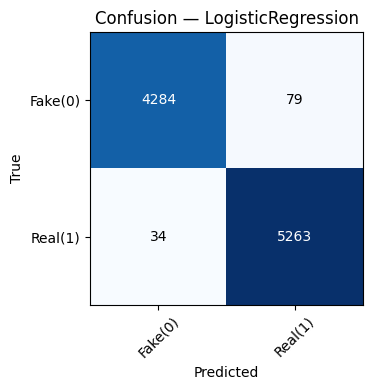

  Metrics for LogisticRegression:
   Accuracy : 0.9883
   Precision: 0.9852
   Recall   : 0.9936
   F1-score : 0.9894
----------------------------------------


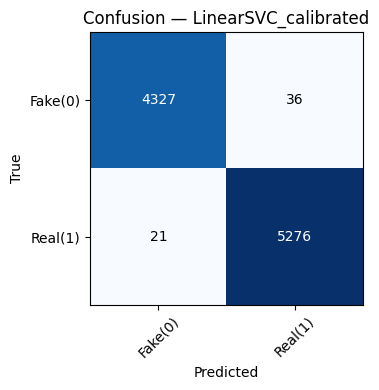

  Metrics for LinearSVC_calibrated:
   Accuracy : 0.9941
   Precision: 0.9932
   Recall   : 0.9960
   F1-score : 0.9946
----------------------------------------


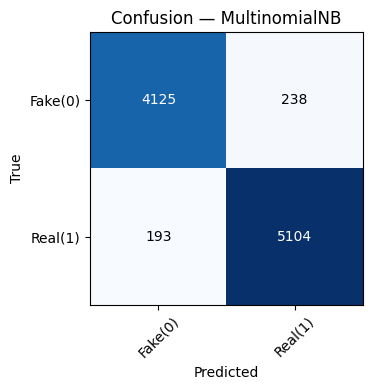

  Metrics for MultinomialNB:
   Accuracy : 0.9554
   Precision: 0.9554
   Recall   : 0.9636
   F1-score : 0.9595
----------------------------------------


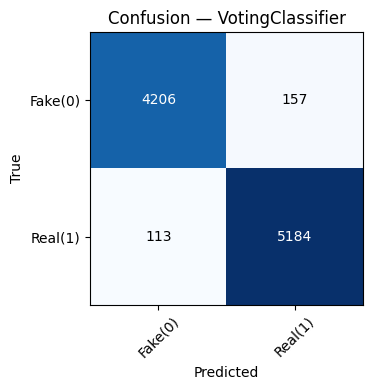

  Metrics for VotingClassifier:
   Accuracy : 0.9720
   Precision: 0.9706
   Recall   : 0.9787
   F1-score : 0.9746
   Voting   : soft
   Weights  : [1 (LR), 1 (SVC), 2 (NB)]
----------------------------------------


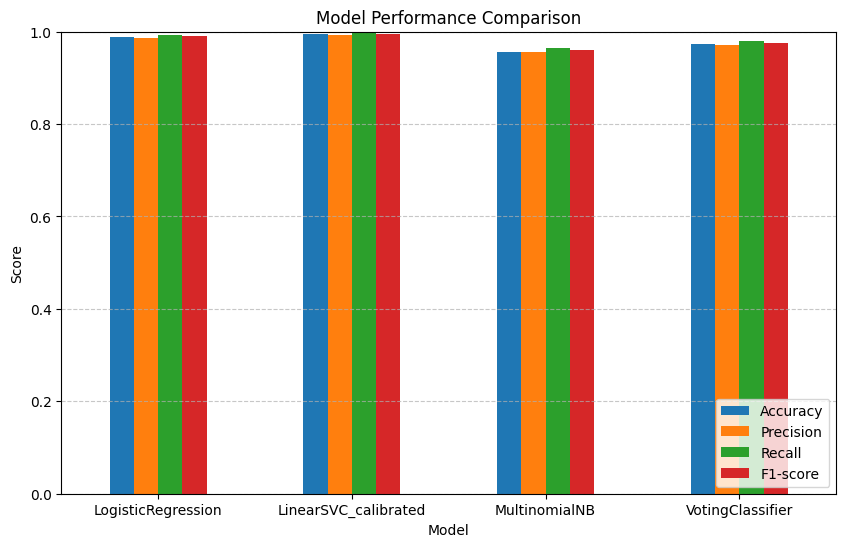

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    fig = plt.figure(figsize=(4.5, 4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # write numbers inside the squares
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


#  Generate predictions, plot confusion matrix, and collect metrics
metrics_summary = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)                 # train model
    preds = model.predict(X_test)               # make predictions
    predictions[name] = preds                   # save in dict

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm,
                          classes=["Fake(0)", "Real(1)"],
                          title=f"Confusion — {name}")

    # Classification metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # Save metrics for comparison
    metrics_summary["Model"].append(name)
    metrics_summary["Accuracy"].append(acc)
    metrics_summary["Precision"].append(prec)
    metrics_summary["Recall"].append(rec)
    metrics_summary["F1-score"].append(f1)

    print(f"  Metrics for {name}:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-score : {f1:.4f}")

    # Extra info for VotingClassifier
    if name == "VotingClassifier":
        print("   Voting   : soft")
        print("   Weights  : [1 (LR), 1 (SVC), 2 (NB)]")

    print("-"*40)


# Convert metrics summary to DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics_summary)

# Plot bar chart comparison
metrics_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(
    kind="bar", figsize=(10,6), rot=0
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)  # scores between 0 and 1
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [9]:
import joblib

# Pick best row depending on which results DataFrame you're using
best_row = results_df.sort_values("f1", ascending=False).iloc[0]   # if using evaluate_and_plot
# best_row = metrics_df.sort_values("F1-score", ascending=False).iloc[0]  # if using confusion-matrix metrics

best_name = best_row["model"]
best_model = models[best_name]

# Retrain on ALL data (X, y) with pipeline included
best_model.fit(X, y)

SAVE_PATH = "best_fake_news_pipeline.joblib"
joblib.dump({"name": best_name, "pipeline": best_model}, SAVE_PATH)

print(f" Saved best model: {best_name} at {SAVE_PATH}")


 Saved best model: LinearSVC_calibrated at best_fake_news_pipeline.joblib


In [10]:
# Train all models once on full dataset and store them
trained_models = {}
for name, model in models.items():
    print(f"Training {name} on full data...")
    model.fit(X, y)
    trained_models[name] = model

# Default best model (already selected earlier)
best_model = trained_models[best_name]

print(" All models trained and stored in trained_models")


Training LogisticRegression on full data...
Training LinearSVC_calibrated on full data...
Training MultinomialNB on full data...
Training VotingClassifier on full data...
 All models trained and stored in trained_models


In [11]:
def predict_text(text):
    if not text.strip():
        return {"label": None, "proba_real": None}

    model = best_model
    try:
        label = model.predict([text])[0]
    except Exception:
        return {"label": None, "proba_real": None}

    proba_real = None
    if hasattr(model, "predict_proba"):
        try:
            proba_real = model.predict_proba([text])[0][1]
        except Exception:
            proba_real = None

    return {"label": label, "proba_real": proba_real}


In [12]:
import ipywidgets as w
from IPython.display import display, clear_output

ui_model_choice = w.Dropdown(
    options=list(trained_models.keys()),
    value=best_name,
    description="Model:"
)

ui_text = w.Textarea(
    value="Paste a news headline or short article here...",
    placeholder="Type or paste text",
    description="Input:",
    layout=w.Layout(width="100%", height="120px")
)

ui_btn = w.Button(description="Predict", button_style="primary")
ui_out = w.Output()

def on_model_change(change):
    global best_model, best_name
    best_name = change["new"]
    best_model = trained_models[best_name]   # switch instantly

ui_model_choice.observe(on_model_change, names="value")

def on_click(_):
    with ui_out:
        clear_output()
        res = predict_text(ui_text.value)
        if res["label"] is None:
            print("Please enter some text.")
            return

        label = "REAL (1)" if res["label"] == 1 else "FAKE (0)"
        print(f"Prediction: {label}")
        print(f"Model Used: {best_name}")

        if best_name == "VotingClassifier":
            print("Voting Weights: [1 (LR), 1 (SVC), 2 (NB)]")

        if res["proba_real"] is not None:
            p = res["proba_real"]

            plt.figure(figsize=(4,2))
            plt.barh(["Real", "Fake"], [p, 1-p], color=["green","red"])
            plt.xlim(0,1)
            plt.title(f"Prediction Probability ({best_name})")
            plt.show()
        else:
            print(f"{best_name} does not provide probability; showing class only.")

ui = w.VBox([ui_model_choice, ui_text, ui_btn, ui_out])
ui_btn.on_click(on_click)
display(ui)
